In [1]:
%load_ext Cython

import pandas as pd
import numpy as np
import datetime
import random
import pickle
from surprise import SVD
from surprise import Dataset
from surprise import Reader
import statistics

from explanation import InfluenceExplainer

In [2]:
from recommender_algo.editable_svd import EditableSVD

In [12]:
# Load pre-trained model
with open("algo-20m.pickle", "rb") as fp:
    algo = pickle.load(fp)
    
# Init list of movies
movies_df = pd.read_csv("../data/ml-20m/movies.csv", dtype={
   'movieId': int,
   'title': str,
   'genres': str,
})
movies_map = {}
for index, row in movies_df.iterrows():
    movies_map[row['movieId']] = row['title']

user_id = 548328920
means_list = []
std_list = []
for i in range(100):
    # create 10 ratings for random films
    movies_to_rate = []
    for k in range(10):
        key = random.choice(list(movies_map.keys()))
        movies_to_rate.append(key)
    user_rated_items = { key: random.randint(1, 5) for key in movies_to_rate }
    print(user_rated_items)
    
    # Generate recommendations
    algo.fit_new_user(user_id, user_rated_items)
    top_n = []
    for i in movies_map:
        # Filter out rated movies
        if i not in user_rated_items:
            prediction = algo.predict(user_id, i)
            top_n.append((prediction.iid, prediction.est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    top_n.sort(key=lambda x: x[1], reverse=True)
    top_n = top_n[:6]
    print(top_n)
    
    influence_explainer = InfluenceExplainer(user_id, user_rated_items, algo)
    
    for recommendation in top_n:        
        film_influences = {}
        for k in range(20):
            explanation = influence_explainer.generate_explanation_for_all(recommendation)
            for (key, influence) in explanation:
                if key not in film_influences:
                    film_influences[key] = []
                film_influences[key].append(influence)
        # get mean, std of calculated influences
        for influences_list in film_influences.values():
            means_list.append(statistics.mean(influences_list))
            std_list.append(statistics.stdev(influences_list))
    algo.delete_user(user_id)
print("Mean: " + str(statistics.mean(means_list)) + ", std: " + str(statistics.stdev(std_list)))

KeyboardInterrupt: 

In [4]:
# Dump results to pickle
with open("inf1_means_list.pickle", "wb+") as fp:
    pickle.dump(means_list, fp)
with open("inf1_std_list.pickle", "wb+") as fp:
    pickle.dump(std_list, fp)

In [3]:
# Load results from pickle (use if needed)
with open("inf1_means_list.pickle", "rb") as fp:
    means_list = pickle.load(fp)
with open("inf1_std_list.pickle", "rb") as fp:
    std_list = pickle.load(fp)

Mean of mean: 0.16619845302296707, mean of std: 0.12783632799834743


<Figure size 1440x720 with 0 Axes>

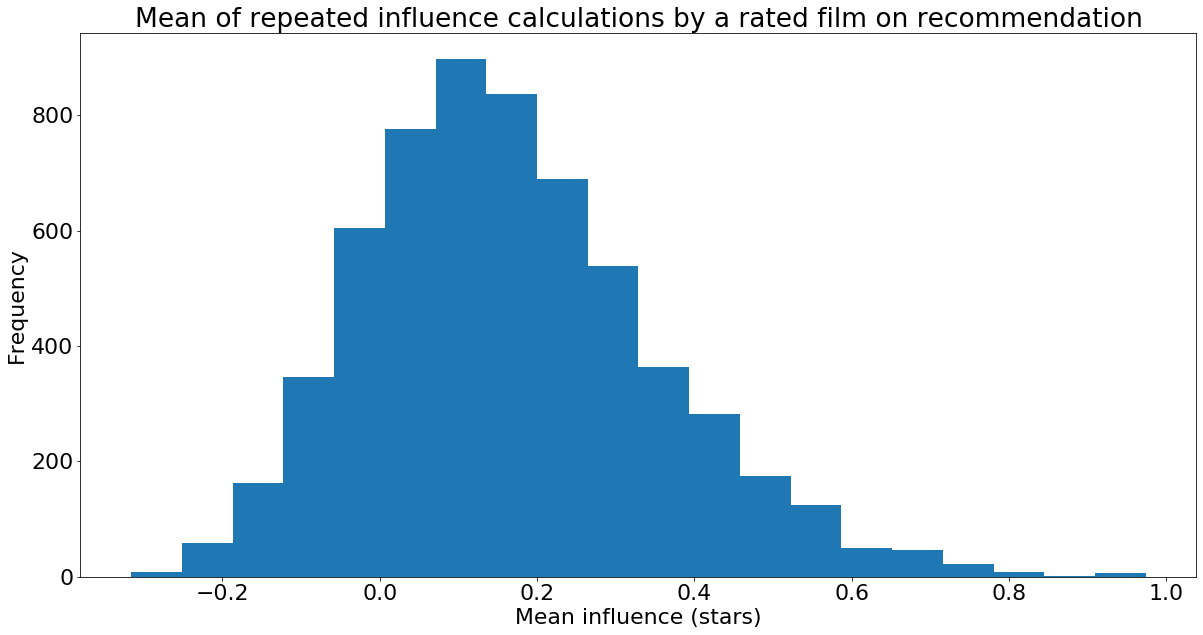

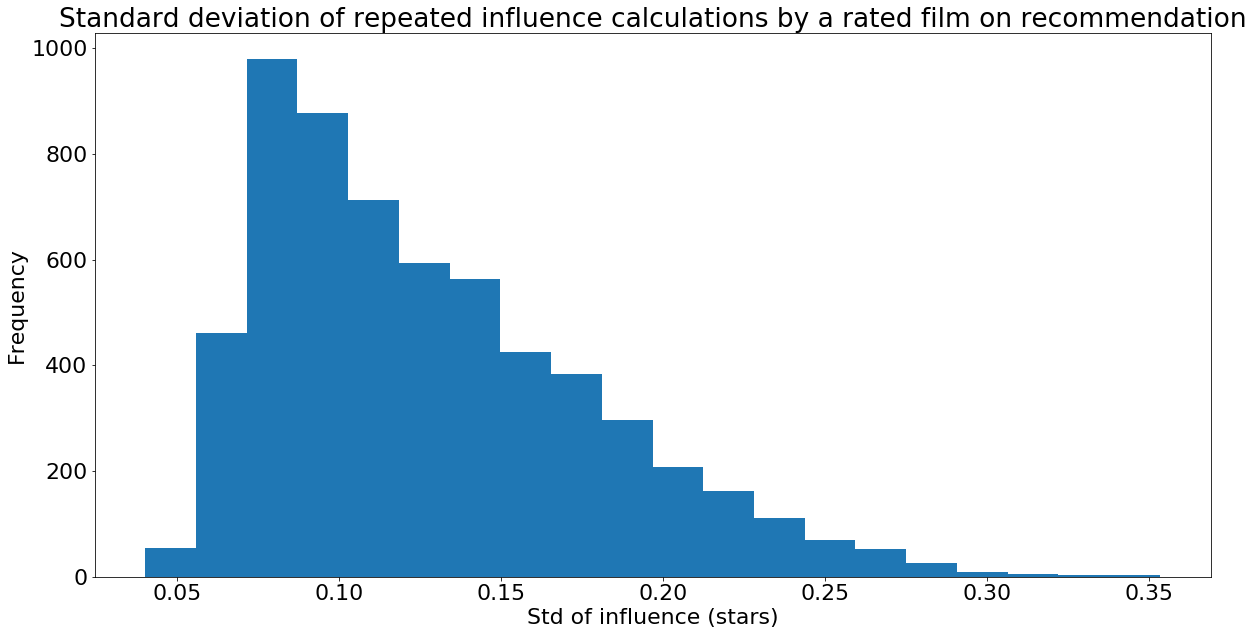

In [6]:
import matplotlib.pyplot as plt
print("Mean of mean: " + str(statistics.mean(means_list)) + ", mean of std: " + str(statistics.mean(std_list)))

fig = plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Mean of repeated influence calculations by a rated film on recommendation')
ax.hist(means_list, bins=20)
plt.xlabel('Mean influence (stars)')
plt.ylabel('Frequency')
plt.show()
fig.savefig('exp1_mean-hist.png')

fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Standard deviation of repeated influence calculations by a rated film on recommendation')
ax.hist(std_list, bins=20)
plt.xlabel('Std of influence (stars)')
plt.ylabel('Frequency')
plt.show()
fig.savefig('exp1_std-hist.png')